# Apply Trained Model on All Images and Collect Measurements

This notebook applies pre-trained model from the [previous notebook](2_Train_Pixel_Classifier.ipynb) to all images in the `Spheroids` folder and save tables with measurements.

It also builds a master table with all measurements from all images in a single table, and provide plots.

## Import libraries

In [2]:
from pathlib import Path
from skimage.io import imread, imsave
import napari_simpleitk_image_processing as nsitk
import numpy as np
import apoc
from napari_skimage_regionprops import regionprops_table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from utilities import refine_labels

## 1. Inputs

Folder to images and number of images in training and validation sets

In [3]:
data_path =  Path("../../data/Spheroids/")

# Load min_area json file, get min_area key-value par and store it in min_area variable
# print message if file is not found
try:
    with open(data_path / 'min_area.json') as f:
        min_area = json.load(f)['min_area']
# Handle exception in case file is not found
except FileNotFoundError:
    print(f"Warning! 'min_area.json' file not found in {data_path}! Using default value of 1000.")
    min_area = 1000

print(f"min_area = ", min_area)

min_area =  1000


Get list of all images in the folder (except for those in `train`, `validation`, `train_annotations` or `control` folders) and store them in a list.

In [4]:
image_path_list = []
# Iterate over all paths inside folder path
for path in data_path.rglob("*"):
     # Check if path is a .tif file
    if (path.is_file() and path.suffix == '.tif'):
         # check if file path does not include 'train', 'validation', 'train_annotations' or 'control' folder
        if ('train' not in path.parts) and ('validation' not in path.parts) and ('Outputs' not in path.parts) and ('train_annotations' not in path.parts) and ('control' not in path.parts):
            image_path_list.append(path)

Load pre-trained model from the previous notebook.

In [5]:
model_path = data_path / 'my_model.cl'

## 2. Define workflow to run model and post-processing functions in a single function

In [6]:
def workflow(image_path, model_path, min_area):
    image = imread(image_path)
    model = apoc.PixelClassifier(opencl_filename=model_path)

    # Provide standard deviation filter as extra channel
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])

    # Get model prediction
    prediction = model.predict(image=image_stack)

    # Instance Segmentation and Post-process labels
    labels_post_processed = refine_labels(prediction, min_area)
    
    # Get size measurements
    table = regionprops_table(
        image,
        labels_post_processed,
        size=True,
        shape=True,
        intensity=False,
        napari_viewer=None,
    )
    
    return labels_post_processed, table

## 3. Batch Processing
For each path in the list, read the image, apply the workflow and save the results in an `Output` folder.

Labeled images and tables are saved inside the `Output` folder with the same name as the original image + "\_labels" or "\_table", respectively.

Measure features and save them in a table for each image. Concatenate all tables into a single master table.


In [8]:
master_df = pd.DataFrame()
# iterate over list of paths
for image_path in image_path_list:
    # applies workflow on image
    label_image, table = workflow(image_path, model_path, min_area)
    # Create an empty "Outputs" folder (if not there already)
    output_folder_path = Path(image_path.parent, 'Outputs')

    output_folder_path.mkdir(exist_ok = True)
    
    # Create a "image_labels.tif" path
    output_label_image_path = Path(output_folder_path, image_path.stem + '_labels.tif')
    # Store the label_image in the created "image_labels.tif" path
    imsave(output_label_image_path, label_image)
    
    # Create a "image_table.csv" path
    output_table_path = Path(output_folder_path, image_path.stem + '_table.csv')
    # Store the table in the created "image_table.csv" path
    table.to_csv(output_table_path)

    table['file_name'] = image_path.stem[:13] # Change this once/if same file names are used
    time_of_acquisition = image_path.parent.stem
    table['time_of_acquisition'] = time_of_acquisition
    group = image_path.parent.parent.stem
    table['group'] = group
    master_df = pd.concat([master_df, table])

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15056\2738699029.py:14: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\Patient 3\Before\Outputs\organoids_B070799EFE6-C990-4640-8A06-7F871FDA031F_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15056\2738699029.py:14: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\Patient 3\Before\Outputs\organoids_B08D1CF1EC4-FE5B-43FE-9067-B4964B21ED4D_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15056\2738699029.py:14: UserWarning: C:\Users\mazo260d\Documents\GitHub\Brightfield-3D-models-image-analysis\data\Spheroids\Patient 3\Before\Outputs\organoids_C08696DB4E4-09A0-4C21-8CF1-75061F354A13_labels.tif is a low contrast image
  imsave(output_label_image_path, label_image)
C:\Users\mazo260

Calculate the log of the areas for better plot visualization.

In [9]:
master_df['log_of_area'] = np.log10(master_df['area'])
master_df.head(8)

,label,area,bbox_area,equivalent_diameter,convex_area,extent,local_centroid-0,local_centroid-1,solidity,feret_diameter_max,...,minor_axis_length,orientation,eccentricity,aspect_ratio,roundness,circularity,file_name,time_of_acquisition,group,log_of_area
0,1,4189.0,6586.0,73.031503,4745.0,0.636046,35.638816,40.540941,0.882824,89.693924,...,68.211539,1.382950,0.559533,1.206552,0.787431,0.578733,organoids_B07,Before,Patient 3,3.622110
1,2,1701.0,2279.0,46.537947,1979.0,0.746380,18.488536,28.120517,0.859525,58.523500,...,42.678916,1.412971,0.634278,1.293486,0.710664,0.534255,organoids_B07,Before,Patient 3,3.230704
2,3,1591.0,2703.0,45.008045,1865.0,0.588605,25.691389,26.662476,0.853083,59.203040,...,41.107282,0.647059,0.680908,1.365433,0.642987,0.620938,organoids_B07,Before,Patient 3,3.201670
3,4,1052.0,1890.0,36.598470,1279.0,0.556614,20.500000,19.591255,0.822518,56.639209,...,29.345692,0.747044,0.825959,1.773900,0.494287,0.531980,organoids_B07,Before,Patient 3,3.022016
0,1,1456.0,2162.0,43.056205,1663.0,0.673451,21.708104,24.419643,0.875526,53.000000,...,40.889127,-0.751611,0.513983,1.165773,0.815883,0.674416,organoids_B08,Before,Patient 3,3.163161
1,2,2193.0,4270.0,52.841407,2898.0,0.513583,34.979480,41.254446,0.756729,78.771822,...,49.700011,-0.877257,0.738309,1.482662,0.514223,0.381711,organoids_B08,Before,Patient 3,3.341039
2,3,1090.0,1665.0,37.253605,1205.0,0.654655,19.008257,19.421101,0.904564,52.697249,...,28.125680,0.560897,0.841802,1.852585,0.511181,0.699016,organoids_B08,Before,Patient 3,3.037426
3,4,1228.0,1927.0,39.541600,1446.0,0.637260,20.925081,25.666938,0.849239,51.078371,...,37.809112,-1.175120,0.588521,1.236886,0.714918,0.619073,organoids_B08,Before,Patient 3,3.089198


Save master table to disk

In [10]:
master_df.to_csv(data_path / ('master_table.csv'))

## 4. Plotting

### Plot area boxplots

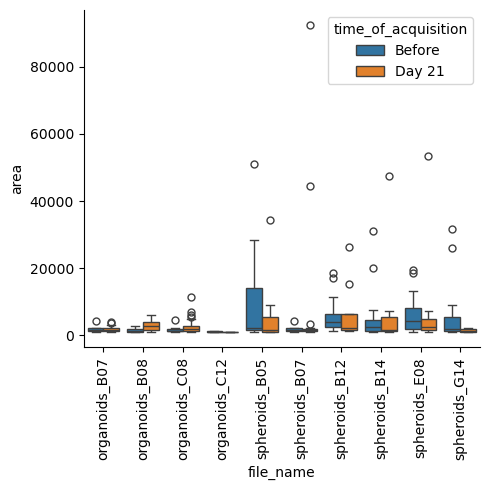

In [11]:
g = sns.catplot(data=master_df, x='file_name', y='area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot circularity boxplots

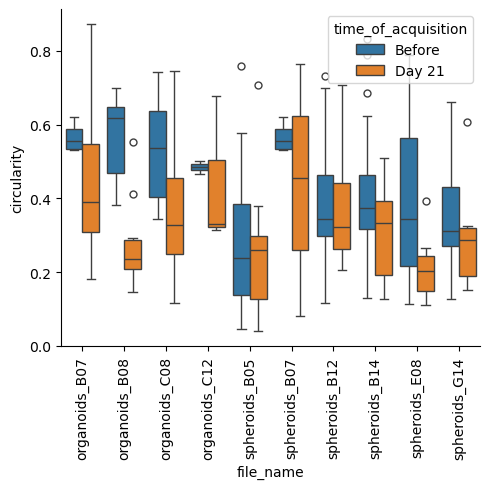

In [12]:
g = sns.catplot(data=master_df, x='file_name', y='circularity', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot log of area boxplots

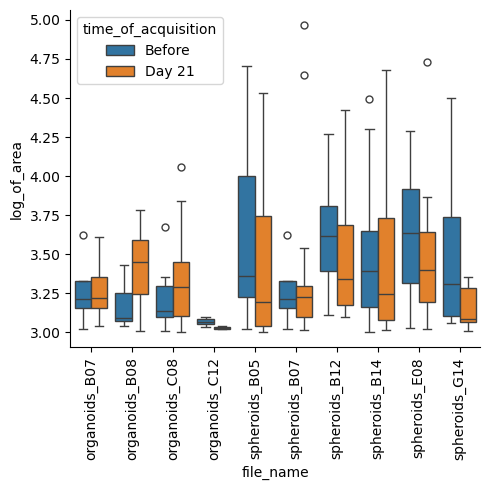

In [13]:
g = sns.catplot(data=master_df, x='file_name', y='log_of_area', hue='time_of_acquisition', kind='box', legend_out=False)
plt.draw()
# set rotation
g.set_xticklabels(labels=master_df['file_name'].unique(), rotation=90)
plt.tight_layout()

### Plot each file in a different plot

Difference between log of areas for each file (before and after):

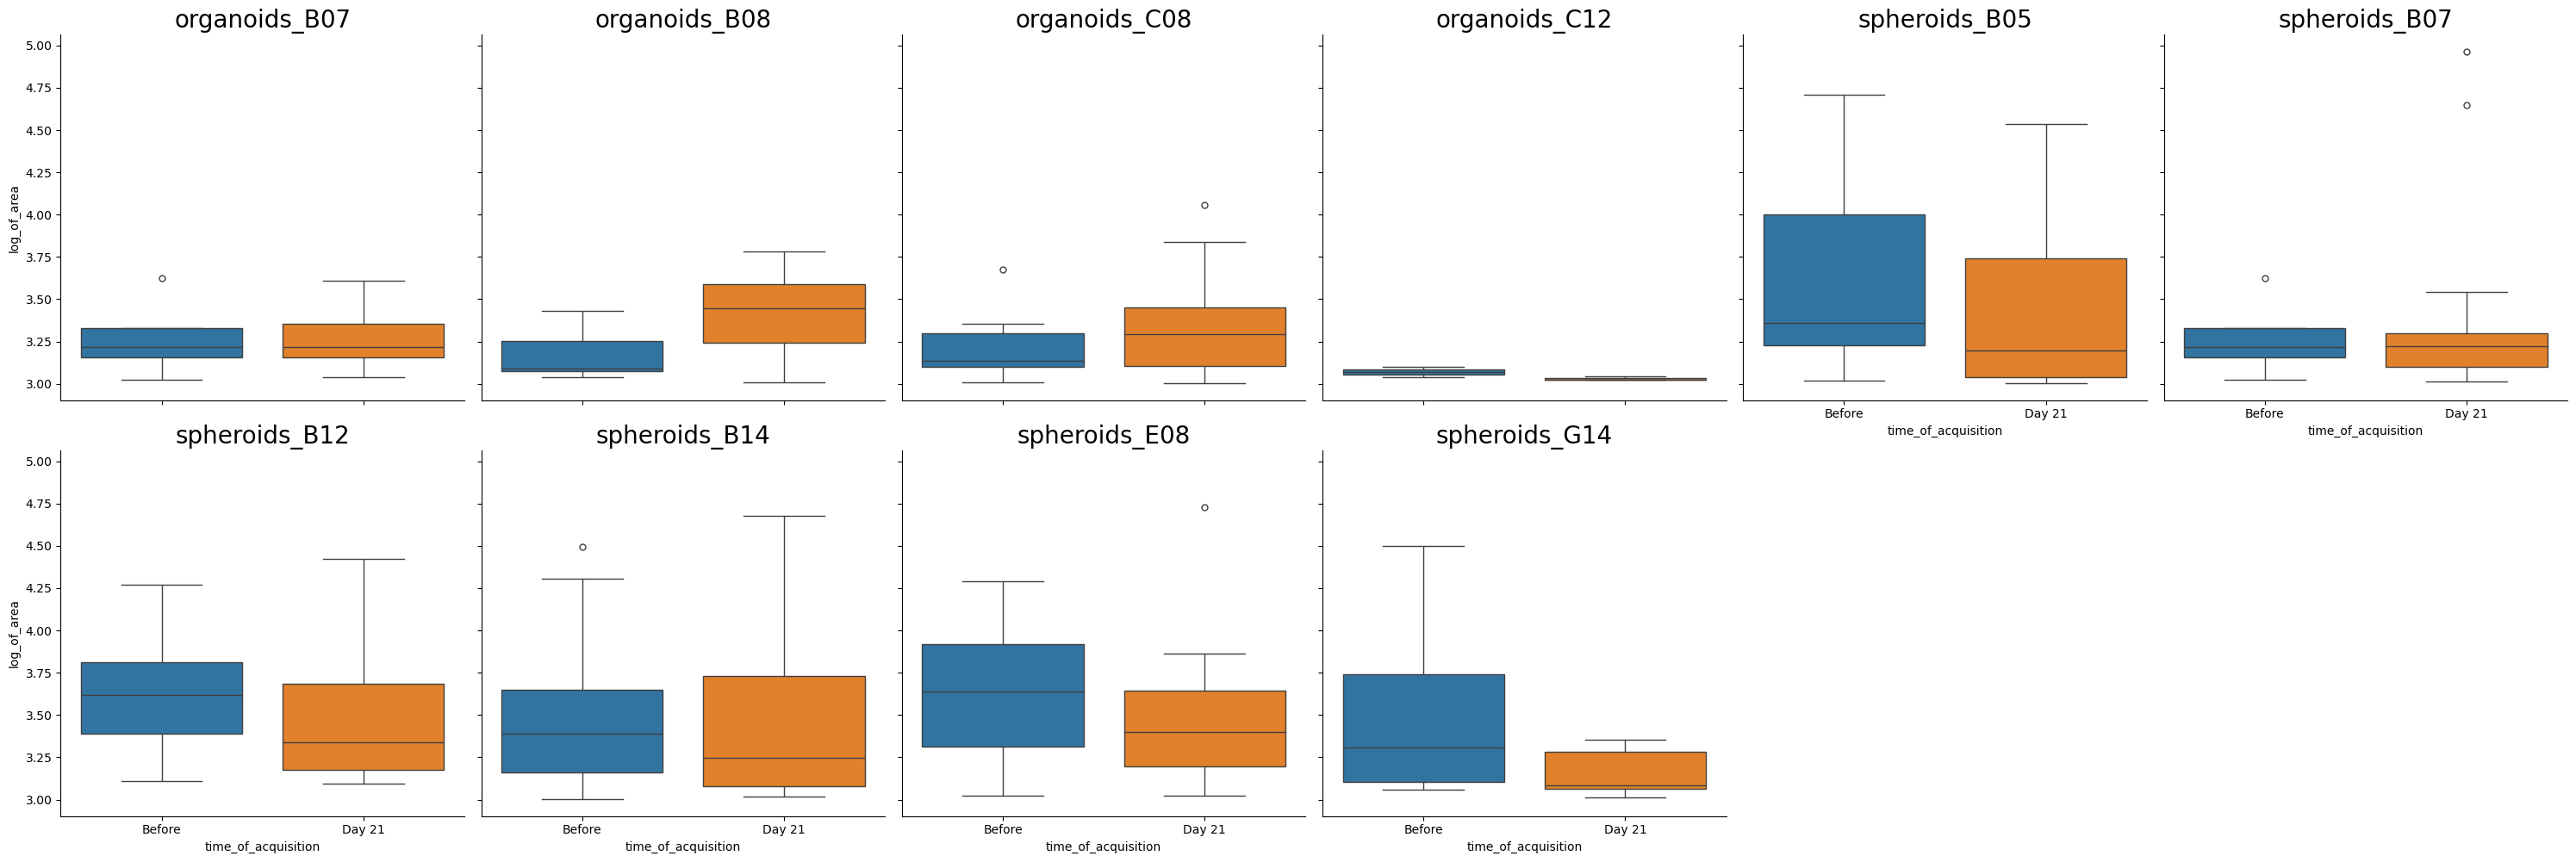

In [14]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='log_of_area', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)

Difference between circularity for each file (before and after):

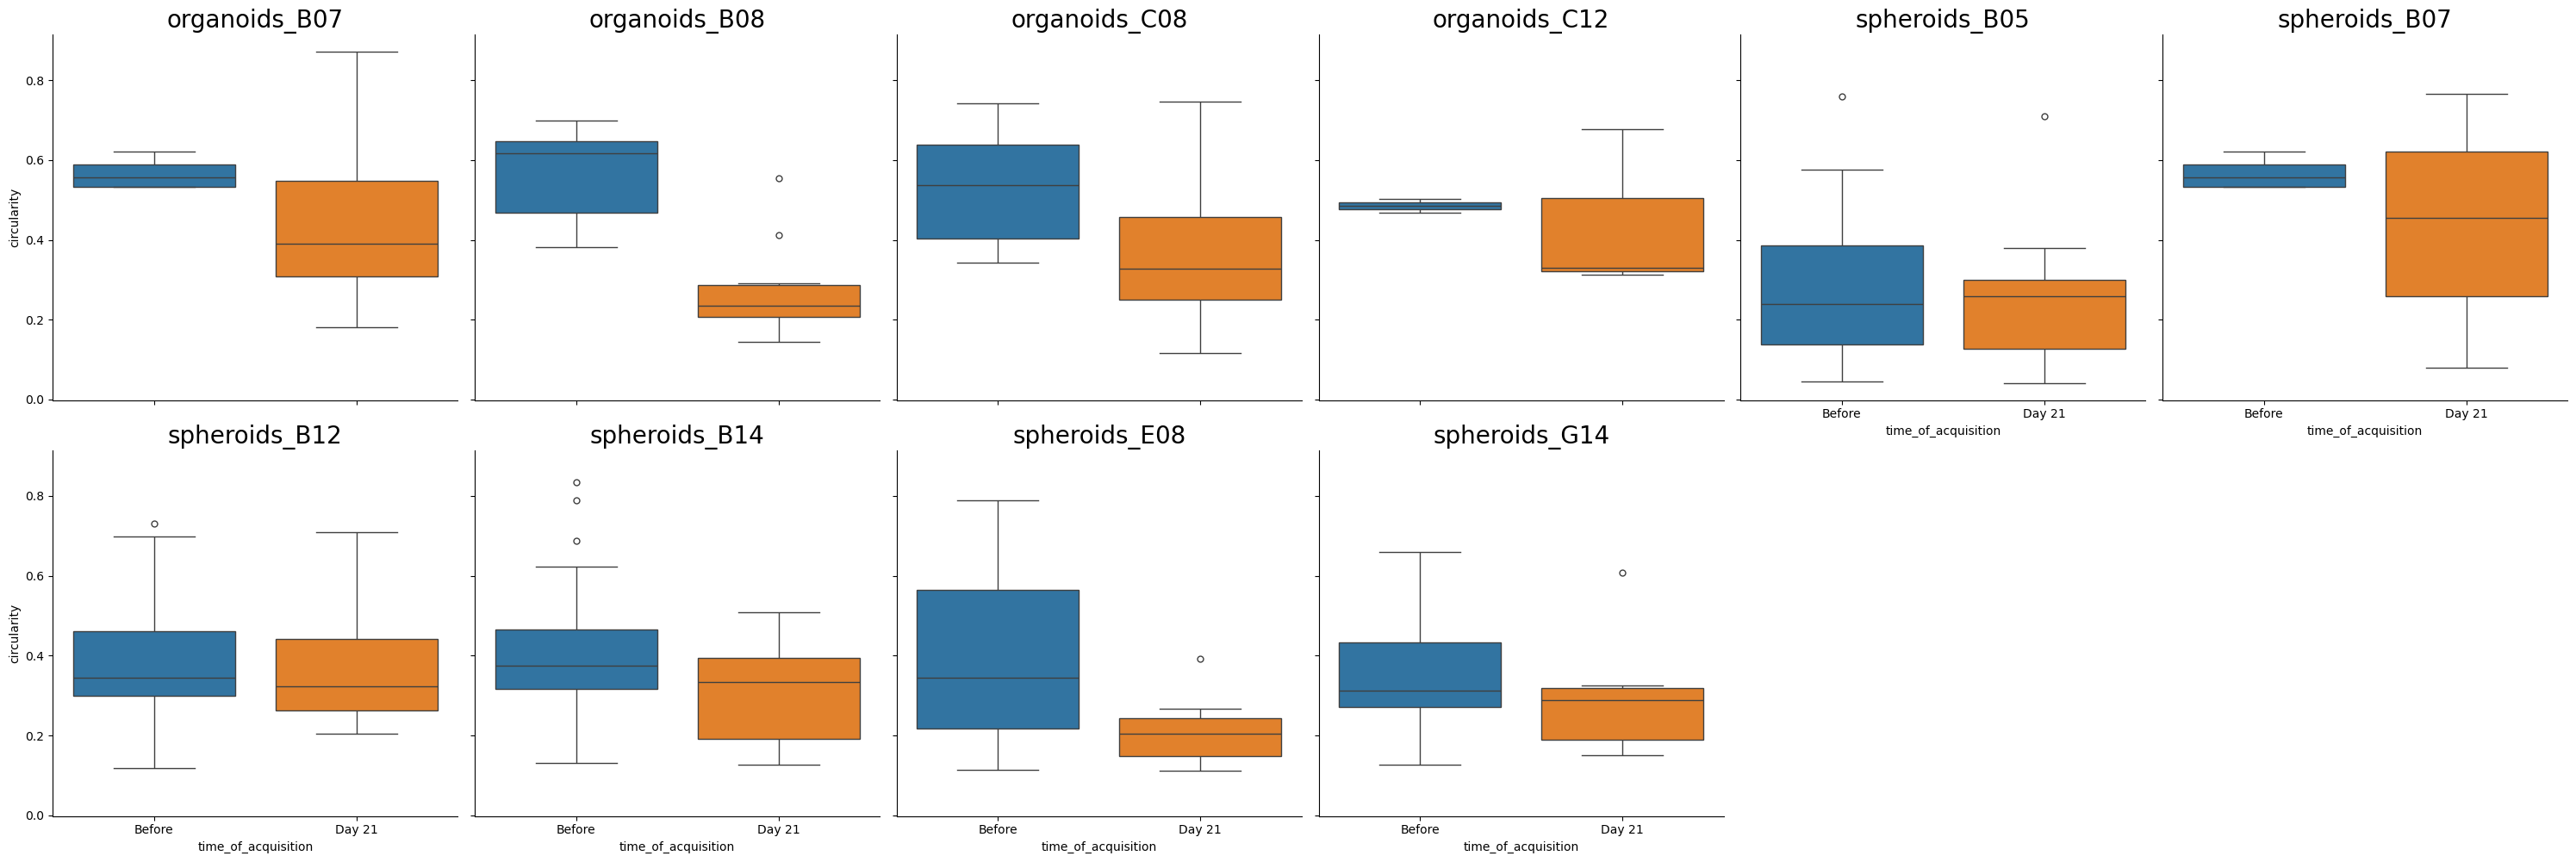

In [15]:
g = sns.catplot(data=master_df,  x='time_of_acquisition', y='circularity', hue='time_of_acquisition', col='file_name', col_wrap = 6, kind='box', legend_out=False)
g.set_titles(col_template='{col_name}', size=20)